In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
import joblib
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv("/content/online_retail_data.csv")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# Convert datetime (safely)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Loại bỏ rows lỗi
df = df.dropna(subset=['InvoiceDate', 'Quantity', 'UnitPrice'])

# Loại đơn hủy (InvoiceNo bắt đầu bằng 'C') và loại giá/số lượng <= 0
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

# Tính revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Gộp theo ngày - cách an toàn và gọn: resample trên DatetimeIndex
daily_revenue = df.set_index('InvoiceDate').resample('D')['Revenue'].sum()

# Đảm bảo frequency hàng ngày, điền các ngày thiếu bằng 0, sắp xếp index
daily_revenue = daily_revenue.asfreq('D', fill_value=0).sort_index()

# Scale (nếu muốn) — nhớ dùng nhất quán cho tất cả model
daily_revenue = daily_revenue / 10000.0

/tmp/ipython-input-2410890472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')


In [6]:
daily_revenue

,Revenue
InvoiceDate,
2010-12-01,5.896079
2010-12-02,4.774838
2010-12-03,4.694371
2010-12-04,0.000000
2010-12-05,3.177495
...,...
2011-12-05,8.874196
2011-12-06,5.671321
2011-12-07,7.543916


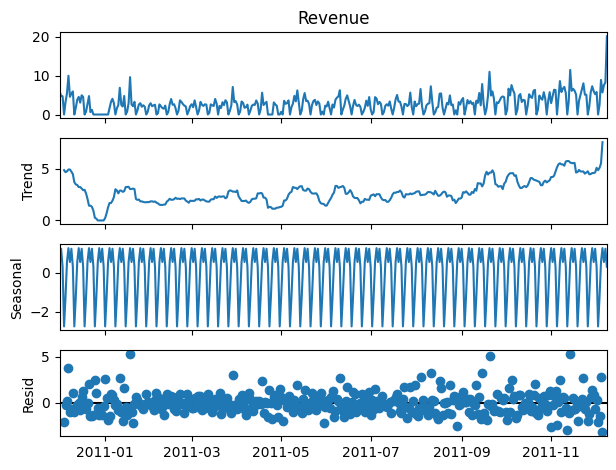

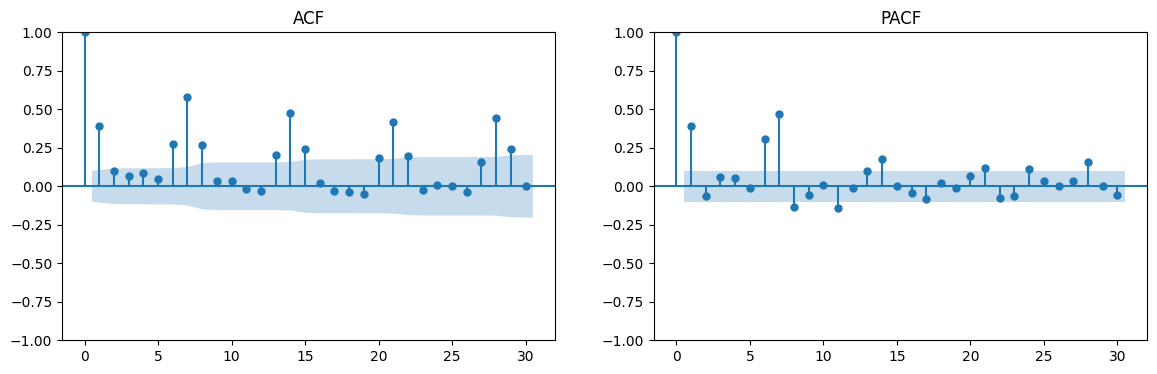

In [8]:
# 2) EDA: seasonal decompose & ACF
# Nếu seasonality hàng tuần, dùng period=7
decomp = seasonal_decompose(daily_revenue, model='additive', period=7)
decomp.plot()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(daily_revenue, lags=30, ax=axes[0])
plot_pacf(daily_revenue, lags=30, ax=axes[1])
axes[0].set_title("ACF")
axes[1].set_title("PACF")
plt.show()

In [9]:
# 3) Auto ARIMA
auto_model = auto_arima(
    daily_revenue,
    seasonal=True, m=7,
    stepwise=True, trace=True,
    error_action="ignore", suppress_warnings=True,
    max_p=5, max_q=5, max_d=2,
    max_P=2, max_Q=2, max_D=1
)
print(auto_model.summary())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1720.813, Time=0.04 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1524.850, Time=0.22 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1536.753, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1718.905, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1706.628, Time=0.09 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1505.488, Time=0.48 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1454.365, Time=1.48 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1456.630, Time=0.61 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=1455.657, Time=2.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1453.764, Time=1.42 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1562.548, Time=0.74 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1601.643, Time=0.60 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=1510.290, Time=1.47 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=1430.920, Time=2.21 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[7] intercept   : AIC=1534.272, Time=0.65 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=1431.871, Time=0.98 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,2)[7] intercept   : AIC=1432.919, Time=3.49 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=1579.669, Time=0.29 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=1431.107, Time=2.09 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[7] intercept   : AIC=1405.462, Time=1.70 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,2)[7] intercept   : AIC=1512.410, Time=0.91 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[7] intercept   : AIC=1410.376, Time=2.73 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,2)[7] intercept   : AIC=1407.461, Time=4.28 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=1550.947, Time=0.39 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,1)[7] intercept   : AIC=1406.018, Time=3.17 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[7] intercept   : AIC=1402.743, Time=2.69 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,2)[7] intercept   : AIC=1506.507, Time=1.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[7] intercept   : AIC=1408.053, Time=2.43 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,2)[7] intercept   : AIC=1404.726, Time=5.40 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[7] intercept   : AIC=1549.215, Time=0.91 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(2,0,1)[7] intercept   : AIC=1403.234, Time=3.62 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[7] intercept   : AIC=1401.972, Time=4.02 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,2)[7] intercept   : AIC=1493.551, Time=1.06 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,1)[7] intercept   : AIC=1406.285, Time=1.58 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,2)[7] intercept   : AIC=1404.003, Time=5.13 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,1)[7] intercept   : AIC=1521.712, Time=0.47 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(2,0,1)[7] intercept   : AIC=1402.469, Time=6.19 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,2)[7] intercept   : AIC=1398.206, Time=4.61 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,2)[7] intercept   : AIC=1484.551, Time=1.27 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[7] intercept   : AIC=1404.735, Time=3.08 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,2)[7] intercept   : AIC=1402.350, Time=7.34 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,1)[7] intercept   : AIC=1503.574, Time=0.62 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,1)[7] intercept   : AIC=1399.284, Time=4.72 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[7] intercept   : AIC=1392.316, Time=5.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,2)[7] intercept   : AIC=1476.753, Time=1.79 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,1)[7] intercept   : AIC=1398.780, Time=2.39 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,2)[7] intercept   : AIC=1402.515, Time=5.06 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,1)[7] intercept   : AIC=1508.970, Time=2.23 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,1)[7] intercept   : AIC=1390.546, Time=7.33 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=4.09 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,0)[7] intercept   : AIC=1446.017, Time=3.25 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,1)[7] intercept   : AIC=1400.745, Time=4.25 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=4.85 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=1401.371, Time=5.23 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=6.16 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,1)[7]             : AIC=1388.390, Time=2.65 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,1)[7]             : AIC=1393.309, Time=1.43 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,0)[7]             : AIC=1433.242, Time=1.99 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,2)[7]             : AIC=1389.646, Time=6.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,0)[7]             : AIC=1445.038, Time=0.77 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,2)[7]             : AIC=1387.552, Time=2.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,2)[7]             : AIC=1475.939, Time=0.97 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,1)[7]             : AIC=1508.037, Time=0.46 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,2)[7]             : AIC=1394.929, Time=1.94 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,2)[7]             : AIC=1400.777, Time=2.30 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,2)[7]             : AIC=1389.132, Time=6.47 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,2)[7]             : AIC=1389.115, Time=5.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,2)[7]             : AIC=1403.493, Time=2.08 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,2)[7]             : AIC=1395.850, Time=3.77 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,2)[7]             : AIC=1400.010, Time=1.37 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(1,0,2)[7]             : AIC=1390.722, Time=4.09 sec

Best model:  ARIMA(4,1,1)(1,0,2)[7]          
Total fit time: 190.117 seconds
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  374
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -684.776
Date:                                Thu, 04 Sep 2025   AIC                           1387.552
Time:                                        17:48:35   BIC                           1422.846
Sample:                                    12-01-2010   HQIC                          1401.567
                                         - 12-09-2011                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------

In [12]:
# 4) Hàm đánh giá và plotting tiện dụng
def evaluate_forecast(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return rmse, mae, r2

def plot_simple_forecast(series, forecast, n_forecast=30, title="Forecast", forecast_color='red'):
    future_idx = pd.date_range(series.index[-1] + pd.Timedelta(days=1),
                               periods=n_forecast, freq='D')
    plt.figure(figsize=(12,6))
    plt.plot(series.index, series, label='Actual')
    plt.plot(future_idx, forecast, label='Forecast', color=forecast_color)
    plt.axvline(series.index[-1], color='gray', linestyle='--')
    plt.legend()
    plt.title(title)
    plt.show()

In [15]:
# 5) Grid Search SARIMA (sửa tham số hàm để dùng series input)
def sarima_grid_search(series,
                       p_range=range(0,3), d_range=[1], q_range=range(0,3),
                       P_range=range(0,2), D_range=[1], Q_range=range(0,2),
                       m=7, verbose=True):
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, [m]))

    best_aic = np.inf
    best_order = None
    best_seasonal = None
    best_res = None
    tried = 0
    total = len(pdq) * len(seasonal_pdq)
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            tried += 1
            if verbose:
                print(f"Trying {tried}/{total}: order={param} seasonal={param_seasonal} ...", end='')
            try:
                mod = SARIMAX(series,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                res = mod.fit(disp=False)
                if verbose:
                    print(f" AIC={res.aic:.2f}")
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = param
                    best_seasonal = param_seasonal
                    best_res = res
            except Exception as e:
                if verbose:
                    print(" failed")
                continue

    print("✅ Best SARIMA model:")
    print("Order:", best_order, "Seasonal:", best_seasonal, "AIC:", best_aic)
    return best_res, best_order, best_seasonal

# 6) Rolling evaluation cho SARIMA tối ưu
def rolling_eval_sarima(series, order, seasonal_order, initial_train=120, horizon=30):
    rmse_list, mae_list, r2_list = [], [], []
    n = len(series)
    for start in range(initial_train, n - horizon, horizon):
        train = series[:start]
        test = series[start:start+horizon]

        sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
        sarima_fit = sarima.fit(disp=False)
        preds = sarima_fit.forecast(len(test))

        rmse, mae, r2 = evaluate_forecast(test, preds, name=f"SARIMA ({start})")
        rmse_list.append(rmse); mae_list.append(mae); r2_list.append(r2)

    print("="*40)
    print("Rolling Evaluation (SARIMA best):")
    print(f"RMSE: {np.mean(rmse_list):.4f}")
    print(f"MAE : {np.mean(mae_list):.4f}")
    print(f"R²  : {np.mean(r2_list):.4f}")
    print("="*40)

In [16]:
# 7) Chạy Grid Search + Rolling
best_res, best_order, best_seasonal = sarima_grid_search(daily_revenue,
                                                        p_range=range(0,3), q_range=range(0,3),
                                                        P_range=range(0,2), Q_range=range(0,2),
                                                        m=7, verbose=True)

rolling_eval_sarima(daily_revenue, best_order, best_seasonal,
                    initial_train=120, horizon=30)

Trying 1/36: order=(0, 1, 0) seasonal=(0, 1, 0, 7) ... AIC=1589.16
Trying 2/36: order=(0, 1, 0) seasonal=(0, 1, 1, 7) ... AIC=1446.96
Trying 3/36: order=(0, 1, 0) seasonal=(1, 1, 0, 7) ... AIC=1518.85
Trying 4/36: order=(0, 1, 0) seasonal=(1, 1, 1, 7) ... AIC=1444.66
Trying 5/36: order=(0, 1, 1) seasonal=(0, 1, 0, 7) ... AIC=1475.53
Trying 6/36: order=(0, 1, 1) seasonal=(0, 1, 1, 7) ... AIC=1327.38
Trying 7/36: order=(0, 1, 1) seasonal=(1, 1, 0, 7) ... AIC=1405.14
Trying 8/36: order=(0, 1, 1) seasonal=(1, 1, 1, 7) ... AIC=1327.71
Trying 9/36: order=(0, 1, 2) seasonal=(0, 1, 0, 7) ... AIC=1456.97
Trying 10/36: order=(0, 1, 2) seasonal=(0, 1, 1, 7) ... AIC=1326.04
Trying 11/36: order=(0, 1, 2) seasonal=(1, 1, 0, 7) ... AIC=1405.34
Trying 12/36: order=(0, 1, 2) seasonal=(1, 1, 1, 7) ... AIC=1324.84
Trying 13/36: order=(1, 1, 0) seasonal=(0, 1, 0, 7) ... AIC=1537.49
Trying 14/36: order=(1, 1, 0) seasonal=(0, 1, 1, 7) ... AIC=1386.97
Trying 15/36: order=(1, 1, 0) seasonal=(1, 1, 0, 7) ... A

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


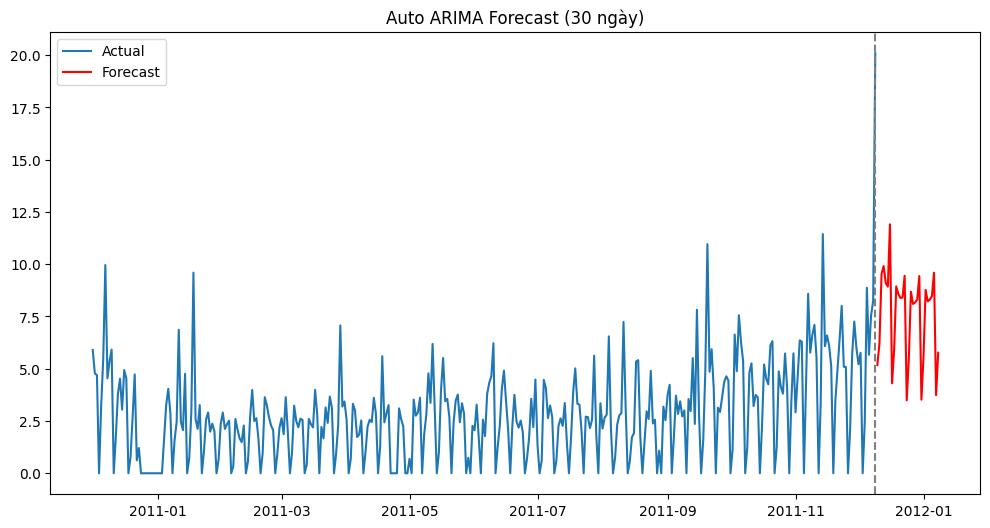

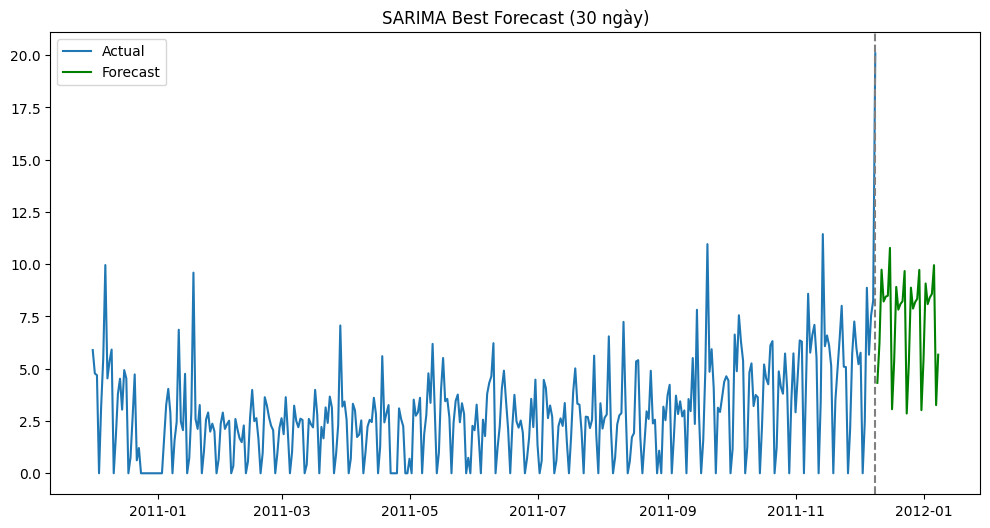

In [17]:
# 8) Vẽ 2 biểu đồ riêng biệt cho forecast 30 ngày
n_forecast = 30
fc_auto = auto_model.predict(n_periods=n_forecast)
plot_simple_forecast(daily_revenue, fc_auto, n_forecast=n_forecast,
                     title="Auto ARIMA Forecast (30 ngày)", forecast_color='red')

# SARIMA best: nếu best_res là kết quả fit trên toàn chuỗi, dùng best_res.forecast
if best_res is not None:
    fc_sarima = best_res.forecast(steps=n_forecast)
    plot_simple_forecast(daily_revenue, fc_sarima, n_forecast=n_forecast,
                         title="SARIMA Best Forecast (30 ngày)", forecast_color='green')

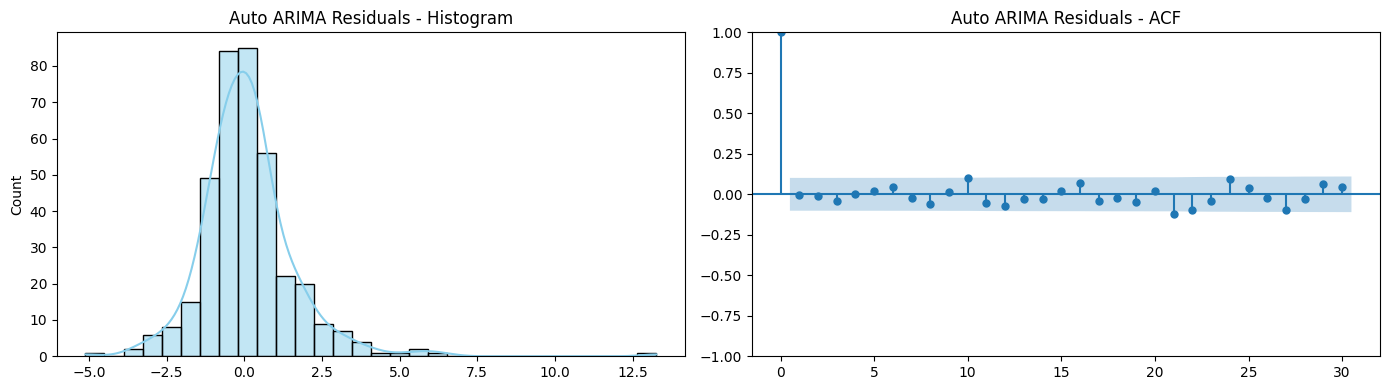

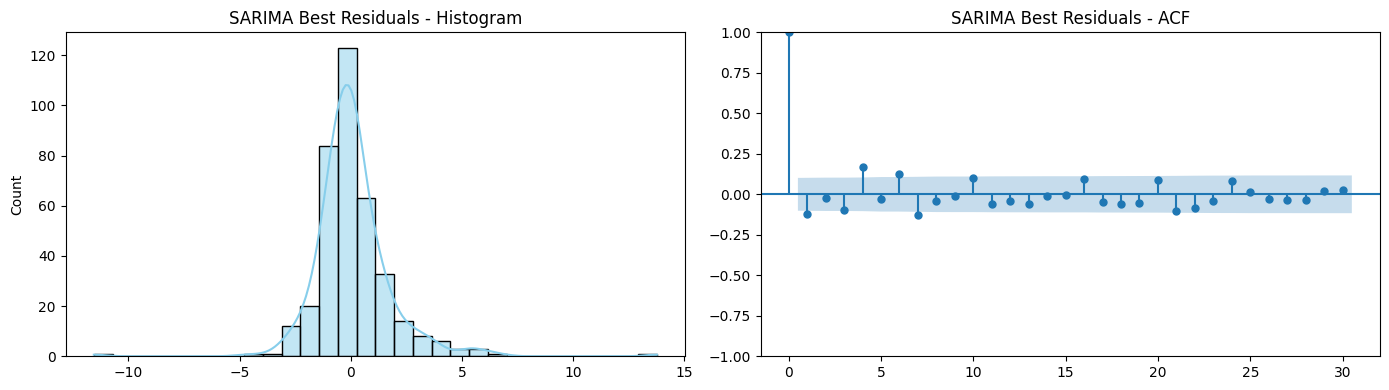

In [19]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Hàm kiểm tra residuals
def residual_diagnostics(resid, lags=30, title="Residual Diagnostics"):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    # Histogram + KDE
    sns.histplot(resid, bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"{title} - Histogram")

    # ACF
    plot_acf(resid, lags=lags, ax=axes[1])
    axes[1].set_title(f"{title} - ACF")

    plt.tight_layout()
    plt.show()

# ================================
# Residuals của Auto ARIMA
# ================================
resid_auto = auto_model.resid()   # pmdarima có sẵn phương thức resid()
residual_diagnostics(resid_auto, title="Auto ARIMA Residuals")

# ================================
# Residuals của SARIMA best
# ================================
resid_sarima = best_res.resid   # statsmodels SARIMAXResults có thuộc tính resid
residual_diagnostics(resid_sarima, title="SARIMA Best Residuals")


In [22]:
import json

# -------------------------
# 9) Lưu model + metrics
# -------------------------

# Lưu Auto ARIMA model
joblib.dump(auto_model, "arima_model.pkl")

# Lưu SARIMA best model (fit trên toàn bộ series)
if best_res is not None:
    joblib.dump(best_res, "sarima_model.pkl")

# Tính metrics trên toàn bộ series (in-sample) để lưu
# (nếu muốn out-of-sample thì cần split train/test trước)
metrics = {}

# Auto ARIMA metrics (in-sample fit)
fitted_auto = auto_model.predict_in_sample()
rmse_a, mae_a, r2_a = evaluate_forecast(daily_revenue, fitted_auto, name="Auto ARIMA (in-sample)")
metrics["Auto_ARIMA"] = {"RMSE": rmse_a, "MAE": mae_a, "R2": r2_a}

# SARIMA metrics (in-sample fit)
if best_res is not None:
    fitted_sarima = best_res.fittedvalues
    rmse_s, mae_s, r2_s = evaluate_forecast(daily_revenue, fitted_sarima, name="SARIMA Best (in-sample)")
    metrics["SARIMA_Best"] = {"RMSE": rmse_s, "MAE": mae_s, "R2": r2_s}

# Lưu vào metrics.json
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("✅ Models and metrics saved successfully!")


Auto ARIMA (in-sample) → RMSE: 1.5672, MAE: 1.0388, R²: 0.5506
SARIMA Best (in-sample) → RMSE: 1.7547, MAE: 1.0922, R²: 0.4366
✅ Models and metrics saved successfully!
